# Incorporating state information

In this notebook we build on the best seq2seq models we have used thus far to see if incorporating state embeddings or state features improves predictions.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from covid_flu import config, utils, time_series, models, plotting

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df_flu = utils.load_flu_data()
df_covid = utils.load_covid_data()
df_states = utils.load_state_data()

In [88]:
scaler_flu = StandardScaler()
scaler_covid = StandardScaler()

df_flu['wili'] = utils.scale_data(df_flu['wili'].values, scaler=scaler_flu)
df_covid['cases'] = utils.scale_data(df_covid['cases'].values, scaler=scaler_covid)

In [136]:
utils.display_all_cols(df_states)

,density_metric,Latitude,is_coastal,airport_arrivals,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,65+,spring,summer,fall,winter,partisan_score,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,cancer,NY_dest,NJ_dest,PA_dest,IL_dest,MD_dest,MA_dest,VA_dest,CA_dest,RI_dest,MI_dest,TX_dest,MO_dest,MN_dest,CT_dest,GA_dest,OH_dest,CO_dest,DE_dest,FL_dest,IN_dest,UT_dest,KY_dest,NE_dest,TN_dest,OR_dest,LA_dest,NC_dest,OK_dest,WA_dest,KS_dest,WI_dest,NH_dest,AZ_dest,SC_dest,AL_dest,IA_dest,NM_dest,WV_dest,NV_dest,AR_dest,ID_dest,ME_dest,MS_dest,VT_dest,SD_dest,ND_dest,MT_dest,WY_dest,NY_is_neighbor,NJ_is_neighbor,PA_is_neighbor,IL_is_neighbor,MD_is_neighbor,MA_is_neighbor,VA_is_neighbor,CA_is_neighbor,RI_is_neighbor,MI_is_neighbor,TX_is_neighbor,MO_is_neighbor,MN_is_neighbor,CT_is_neighbor,GA_is_neighbor,OH_is_neighbor,CO_is_neighbor,DE_is_neighbor,FL_is_neighbor,IN_is_neighbor,UT_is_neighbor,KY_is_neighbor,NE_is_neighbor,TN_is_neighbor,OR_is_neighbor,LA_is_neighbor,NC_is_neighbor,OK_is_neighbor,WA_is_neighbor,KS_is_neighbor,WI_is_neighbor,NH_is_neighbor,AZ_is_neighbor,SC_is_neighbor,AL_is_neighbor,IA_is_neighbor,NM_is_neighbor,WV_is_neighbor,NV_is_neighbor,AR_is_neighbor,ID_is_neighbor,ME_is_neighbor,MS_is_neighbor,VT_is_neighbor,SD_is_neighbor,ND_is_neighbor,MT_is_neighbor,WY_is_neighbor,overall_vacc_rate,child_vacc_rate,State,state
32,10711.4,40.705626,1,2.625045,0.22,0.09,0.13,0.26,0.14,0.16,43.6,66.5,48.1,23.3,-12,18.737,29.756,51.436,5.347,61.622797,14.719,33.425,24.046,24.675,200.165,0.911538,0.061864,0.004793,0.000216,0.000722,0.001985,0.000495,0.000199,0.001692,0.000196,0.000148,0.000147,0.000207,0.033303,0.000321,0.000261,0.000237,0.002078,0.000570,0.000153,0.000171,0.000122,0.000156,0.000232,0.000098,0.000264,0.000368,0.000089,0.000126,0.000117,0.000155,0.001047,0.000143,0.000251,0.000122,0.000119,0.000088,0.000168,0.000233,0.000099,0.000080,0.000857,0.000131,0.012476,0.000081,0.000000,0.000105,0.000209,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,81.7,69.6,NY,New York
30,2789.6,40.143006,1,2.333070,0.23,0.08,0.11,0.27,0.14,0.16,50.6,72.2,54.8,33.0,-7,19.372,27.143,51.199,5.676,72.829584,11.590,36.240,22.909,25.672,200.319,0.028068,0.823014,0.019686,0.000128,0.000793,0.000447,0.000315,0.000072,0.000472,0.000089,0.000099,0.000112,0.000079,0.001903,0.000142,0.000171,0.000154,0.016296,0.000245,0.000081,0.000067,0.000091,0.000065,0.000098,0.000052,0.000080,0.000205,0.000059,0.000067,0.000060,0.000069,0.000368,0.000132,0.000183,0.000051,0.000015,0.000025,0.000137,0.000081,0.000045,0.000041,0.000325,0.000034,0.000566,0.000000,0.000000,0.000114,0.000000,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79.4,72.8,NJ,New Jersey
38,1957.6,40.994593,1,1.621257,0.22,0.08,0.12,0.25,0.14,0.18,47.4,68.6,50.9,28.4,0,6.767,17.371,51.067,5.199,54.960700,11.110,28.104,23.155,29.331,230.835,0.003142,0.028442,0.877457,0.000199,0.012778,0.000454,0.000731,0.000079,0.000352,0.000216,0.000143,0.000188,0.000158,0.000587,0.000222,0.002901,0.000164,0.069599,0.000248,0.000159,0.000125,0.000229,0.000058,0.000202,0.000053,0.000180,0.000314,0.000203,0.000058,0.000106,0.000117,0.000366,0.000156,0.000250,0.000151,0.000091,0.000100,0.011997,0.000114,0.000207,0.000065,0.000299,0.000101,0.000294,0.000080,0.000137,0.000137,0.000232,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,82.5,69.7,PA,Pennsylvania
13,1761.9,39.739318,0,4.102417,0.24,0.09,0.12,0.26,0.13,0.15,51.6,73.4,53.8,28.3,-7,16.918,22.729,50.902,5.963,59.266824,12.397,32.078,21.199,27.340,225.471,0.000143,0.000187,0.000201,0.900515,0.000150,0.000173,0.000197,0.000141,0.000231,0.000784,0.000194,0.018036,0.000492,0.000210,0.000285,0.000342,0.000297,0.000204,0.000304,0.015667,0.000116,0.001515,0.000491,0.000354,0.000092,0.000159,0.000204,0.000159,0.000138,0.000288,0.011498,0.000137,0.000223,0.000114,0.000131,

In [126]:
# Hyperparams
BATCH_SIZE = 64
TEST_SIZE = 0.3
EPOCHS = 5
HISTORY_SIZE = 25
TARGET_SIZE = 5
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
HIDDEN_SIZE = 32
PRE_OUTPUT_DENSE_SIZE = 32

# Making train/val/test split
ds_train_flu, ds_val_flu, ds_test_flu, data_dict_flu = time_series.prepare_data(df_flu['wili'].values, 
                                                                                df_flu['state'].values,
                                                                                history_size=HISTORY_SIZE,
                                                                                target_size=TARGET_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                test_size=TEST_SIZE,
                                                                                teacher_forcing=True,
                                                                                states=True)

ds_train_covid, ds_val_covid, ds_test_covid, data_dict_covid = time_series.prepare_data(df_covid['cases'].values, 
                                                                                        df_covid['state'].values,
                                                                                        history_size=HISTORY_SIZE,
                                                                                        target_size=TARGET_SIZE,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        test_size=TEST_SIZE,
                                                                                        teacher_forcing=True,
                                                                                        states=True)

In [127]:
seq2seq_flu = models.Seq2Seq(history_length=HISTORY_SIZE,
                             target_length=TARGET_SIZE,
                             hidden_size=HIDDEN_SIZE,
                             pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                             num_encoder_layers=2,
                             dropout=0.2,
                             state_embed_size=32)

In [128]:
seq2seq_flu.summary()

Model: "model_90"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_155 (InputLayer)          [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
input_156 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 32), (No 4352        input_155[0][0]                  
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 1, 32)        1696        input_156[0][0]                  
___________________________________________________________________________________________

In [129]:
history_flu = seq2seq_flu.fit(ds_train_flu, validation_data=ds_val_flu, epochs=10)

Train for 236 steps, validate for 51 steps
Epoch 1/10
236/236 [==============================] - 16s 69ms/step - loss: 0.2261 - val_loss: 0.0963
Epoch 2/10
236/236 [==============================] - 8s 36ms/step - loss: 0.1027 - val_loss: 0.0886
Epoch 3/10
236/236 [==============================] - 9s 38ms/step - loss: 0.0959 - val_loss: 0.0891
Epoch 4/10
236/236 [==============================] - 9s 40ms/step - loss: 0.0936 - val_loss: 0.0950
Epoch 5/10
236/236 [==============================] - 9s 38ms/step - loss: 0.0927 - val_loss: 0.0968
Epoch 6/10
236/236 [==============================] - 9s 37ms/step - loss: 0.0909 - val_loss: 0.0989
Epoch 7/10
236/236 [==============================] - 9s 37ms/step - loss: 0.0906 - val_loss: 0.0957
Epoch 8/10
236/236 [==============================] - 8s 36ms/step - loss: 0.0903 - val_loss: 0.1031
Epoch 9/10
236/236 [==============================] - 8s 35ms/step - loss: 0.0891 - val_loss: 0.1074
Epoch 10/10
236/236 [==========================

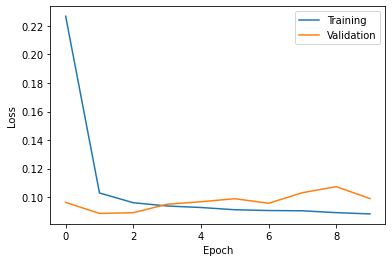

In [130]:
plotting.plot_history(history_flu)

In [131]:
state2idx = {s: i for i, s in enumerate(np.unique(df_flu['state']))}

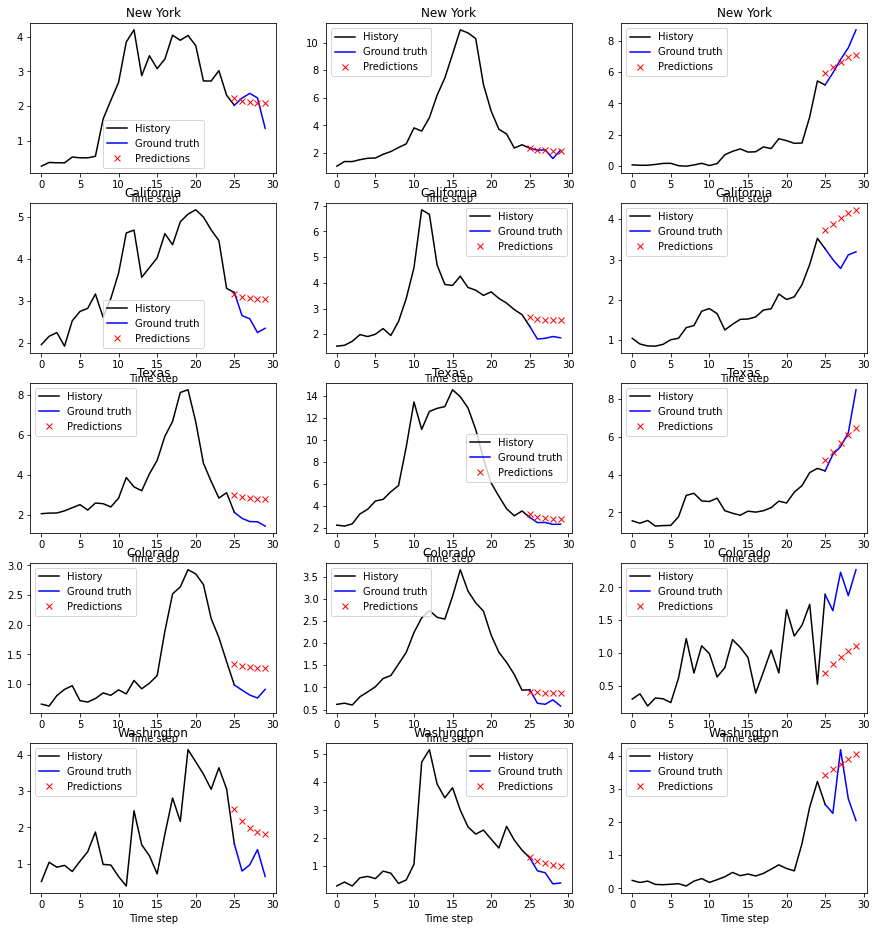

In [132]:
states = ['New York', 'California', 'Texas', 'Colorado', 'Washington']
fig, axs = plt.subplots(len(states), 3, figsize=(3 * len(states), 16))
for i, state in enumerate(states):
    for j, split in enumerate(['train', 'val', 'test']):
        plotting.plot_seq2seq_preds(seq2seq_flu, data_dict_flu, state, 5,
                                    scaler=scaler_flu, split=split, ax=axs[i, j],
                                    state2idx=state2idx)
        axs[i, j].set_title(state)
plt.show()

## Looking at whether the embeddings are predictive of anything

In [133]:
embeds = []
for state, idx in state2idx.items():
    embed = seq2seq_flu.state_embed_model(np.array([[idx]]))
    embeds.append(embed.numpy().flatten())
embeds = np.stack(embeds, 0)

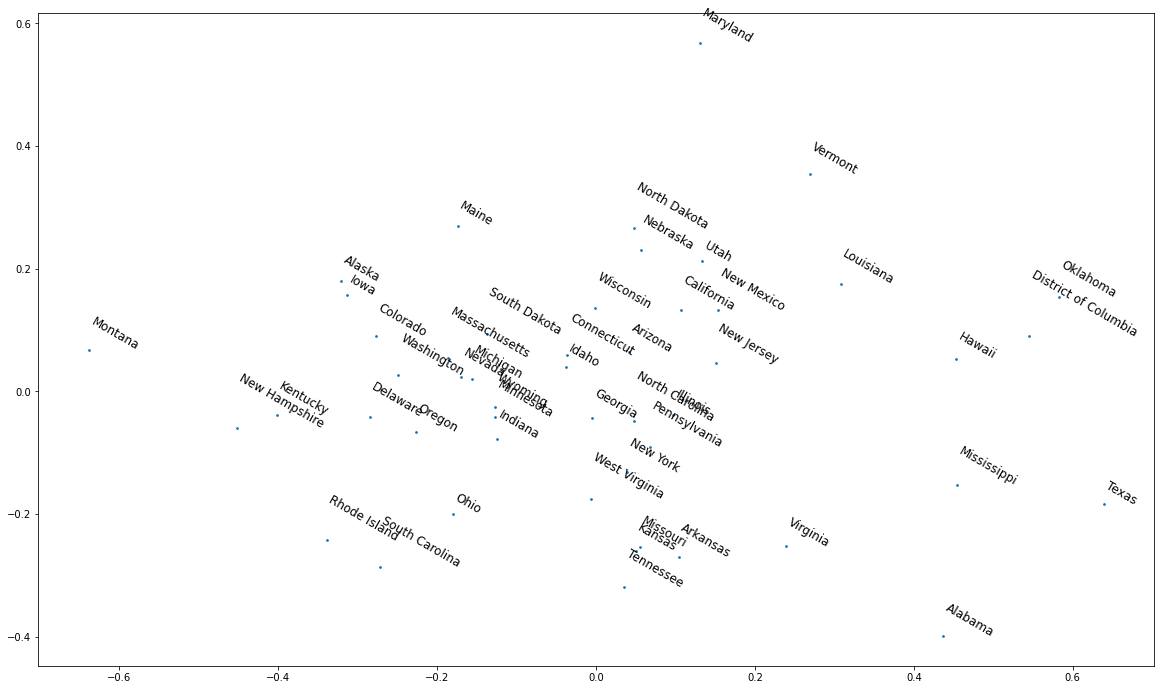

In [135]:
# PCA clustering
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeds)

plt.figure(figsize=(20, 12))
plt.scatter(embeds_pca[:, 0], embeds_pca[:, 1], s=3)
for state, idx in state2idx.items():
    plt.annotate(state, (embeds_pca[idx, 0], embeds_pca[idx, 1]), rotation=-30, size=12)

In [145]:
df_states = df_states.query('state!= "Florida"')
state_features = ['density_metric', 'Latitude', 'is_coastal', 'airport_arrivals', 'spring',
                  'summer', 'fall', 'winter', 'partisan_score', 'minority', 'unemployed',
                  'income', 'nodegree', 'inactivity', 'obesity', 'cancer', 'overall_vacc_rate',
                  'child_vacc_rate']
state_names = df_states['state']
state_embeds = embeds[[state2idx[s] for s in state_names]]

In [180]:
corrs = np.zeros((len(state_features), state_embeds.shape[1]))
corrs2 = np.zeros((len(state_features), state_embeds.shape[1]))
corrs3 = np.zeros((len(state_features), state_embeds.shape[1]))
for i in range(0, len(state_features)):
    for j in range(state_embeds.shape[1]):
        corrs[i, j] = np.correlate(df_states[state_features[i]].values, state_embeds[:, j])
        if i > 0:
            corrs2[i, j] = corrs[i, j]
        if i not in [0, 15]:
            corrs3[i, j] = corrs[i, j]

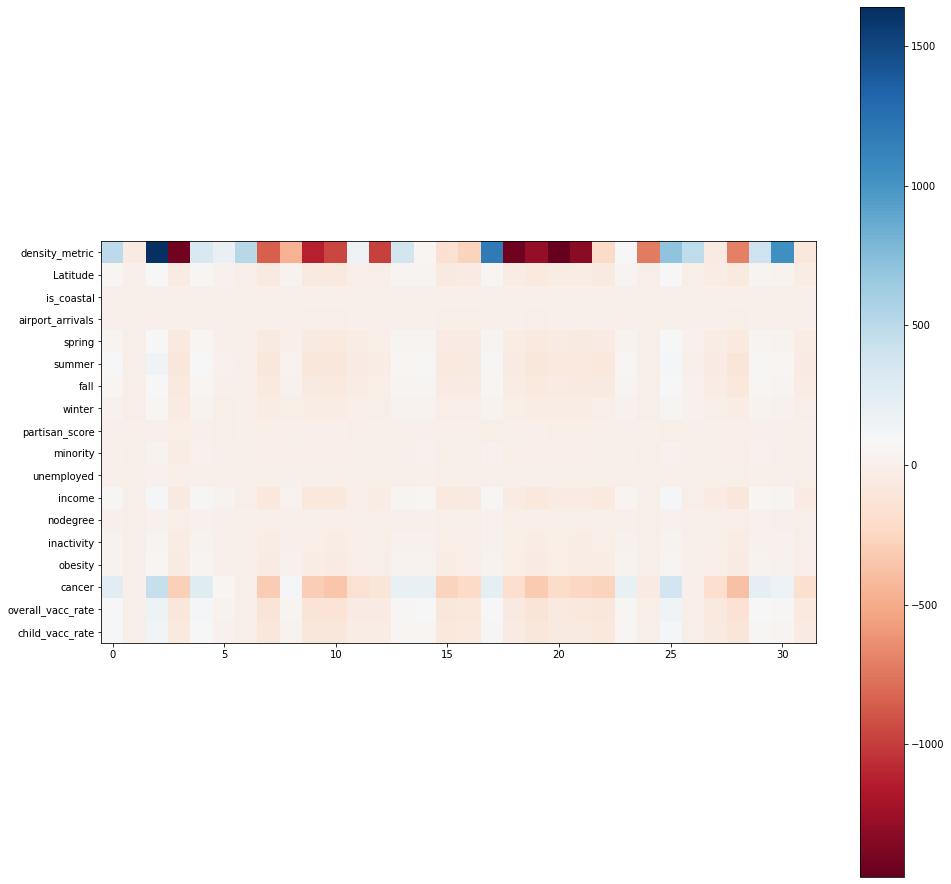

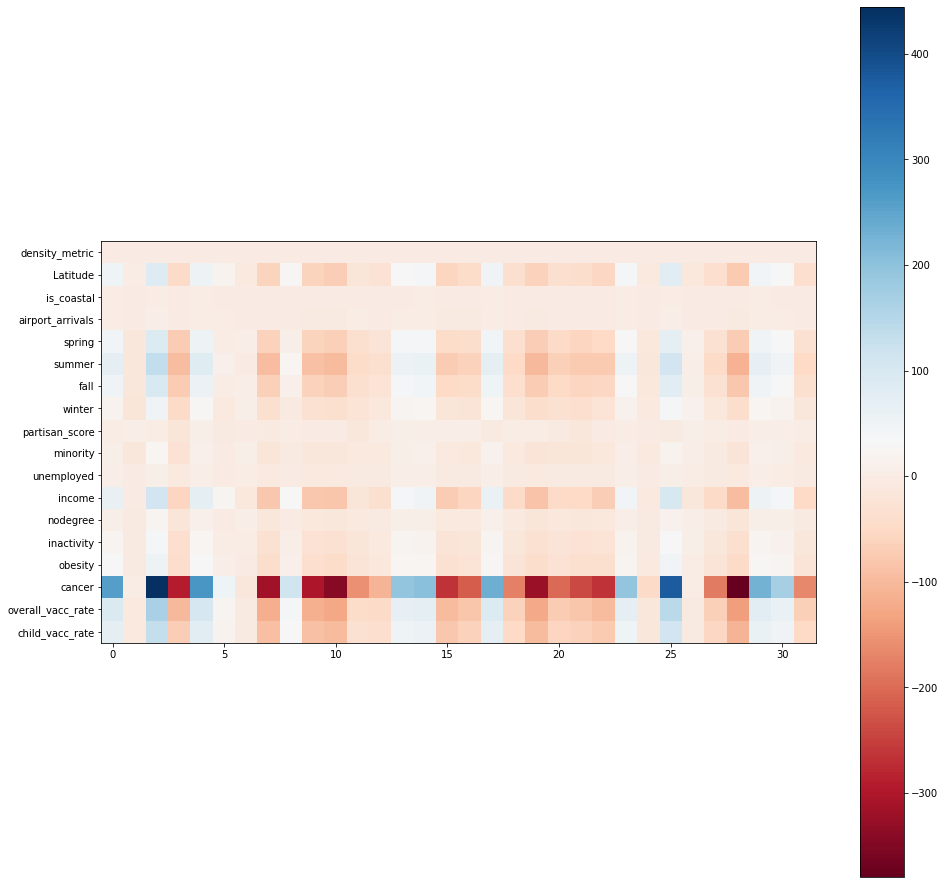

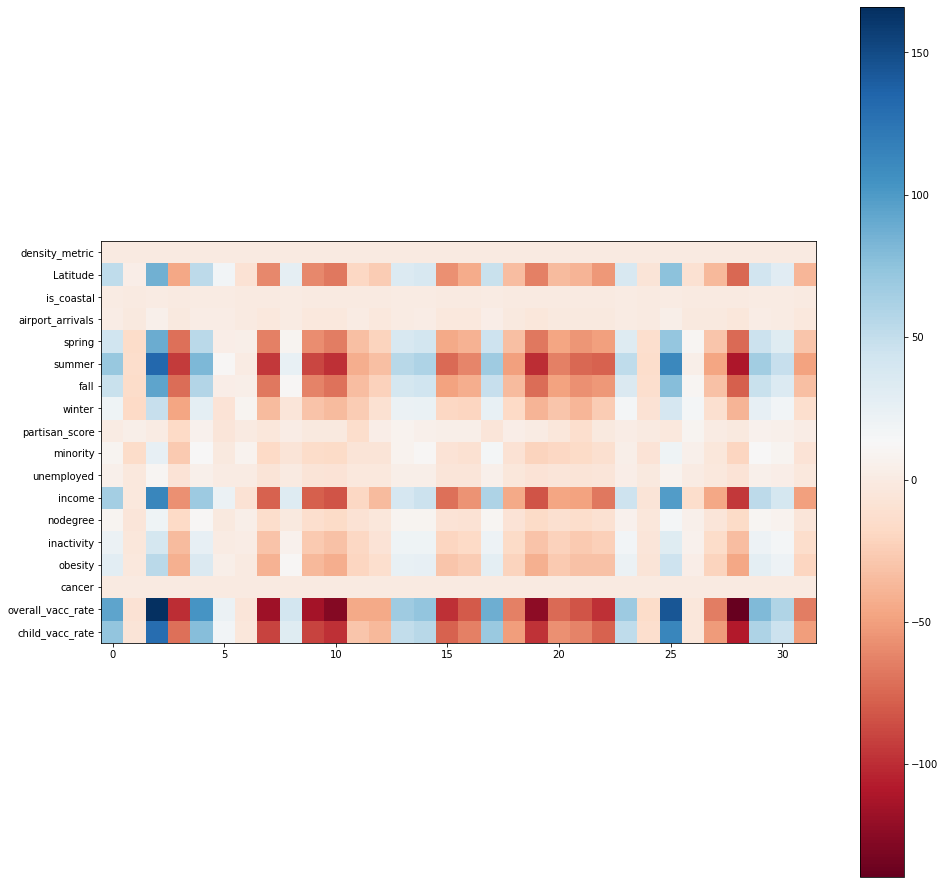

In [190]:
for corr in [corrs, corrs2, corrs3]:
    plt.figure(figsize=(16, 16))
    plt.imshow(corr, cmap='RdBu')
    plt.colorbar()
    plt.yticks(ticks=np.arange(len(state_features)), labels=state_features)
    plt.show()

In [108]:
seq2seq_covid = seq2seq_flu.transfer()

In [109]:
seq2seq_covid.summary()

Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
input_142 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 32), (No 4352        input_141[0][0]                  
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 1, 32)        1696        input_142[0][0]                  
___________________________________________________________________________________________

In [110]:
history_covid = seq2seq_covid.fit(ds_train_covid, validation_data=ds_val_covid, epochs=10)

Train for 45 steps, validate for 11 steps
Epoch 1/10
27/45 [=================>............] - ETA: 3s - loss: 0.0994

InvalidArgumentError:  indices[62,0] = 53 is not in [0, 53)
	 [[node model_79/embedding_29/embedding_lookup (defined at /Users/benjaminlevy/Desktop/Benjamin/School/19_20/Classes/spring/ac209b/project/modelling-infectious-disease/covid_flu/covid_flu/models.py:223) ]] [Op:__inference_distributed_function_181850]

Errors may have originated from an input operation.
Input Source operations connected to node model_79/embedding_29/embedding_lookup:
 model_79/embedding_29/embedding_lookup/178698 (defined at /usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/contextlib.py:112)

Function call stack:
distributed_function


In [ ]:
plotting.plot_history(history_flu)